# Motobike Ambulance Calls Anomaly (Outliers) Detection

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import (cross_val_predict, cross_val_score,
                                     train_test_split, GridSearchCV)
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVR

from motobike_transformers import FeatureSelector, CategoricalTransformer

## PCA, 2D

Explained variance 0.9068130117043913


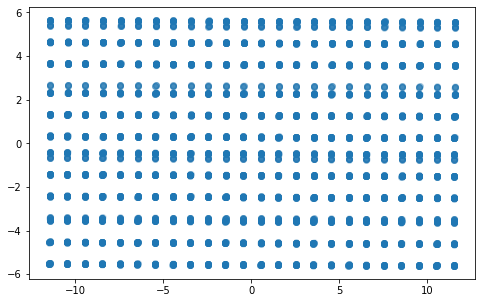

In [3]:
# Dimensionality reduction with PCA
# we have to drop the 'cnt' column as well if we want to work with the new/incoming data for the regression task
data_path = './motorbike_ambulance_calls.csv'
data = pd.read_csv(data_path, index_col=0)

season_encoder = LabelEncoder()
season_encoder.fit(data.season)
data['season'] = season_encoder.transform(data.season)
# X = data.drop(['date'], axis=1)
X = data.drop(['cnt', 'date'], axis=1)

pca = PCA(n_components=2)
pca.fit(X)
X_pca2 = pca.transform(X)

print(f'Explained variance {pca.explained_variance_ratio_.sum()}')

plt.figure(figsize=(8, 5))
plt.scatter(X_pca2[:, 0], X_pca2[:, 1], alpha=0.1)
plt.show()

In [5]:
data['cnt'].describe()

count    17379.000000
mean       189.463088
std        181.387599
min          1.000000
25%         40.000000
50%        142.000000
75%        281.000000
max        977.000000
Name: cnt, dtype: float64

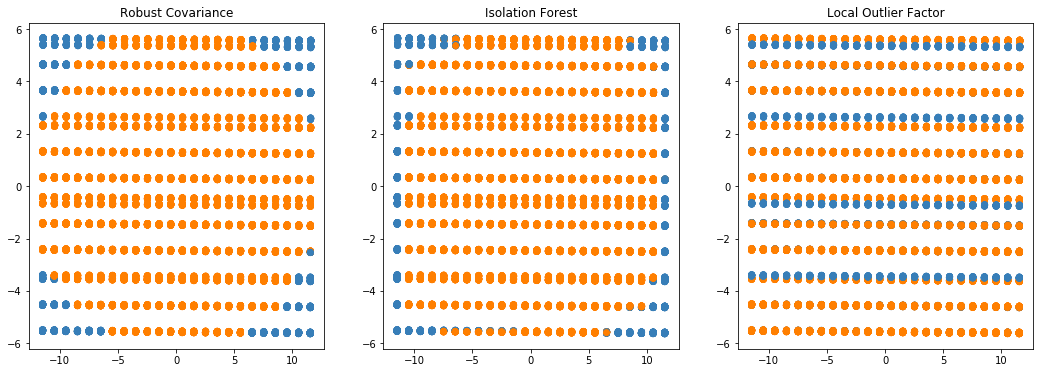

In [7]:
# Look for outliers
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# use PCA's output
X = X_pca2

n_samples = len(X)
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
lof_n_neigbors = 35
rnd_state = 42

clusters = {}

# define outlier/anomaly detection methods to be compared
det_algs = [
    ("Robust Covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=rnd_state)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=lof_n_neigbors, contamination=outliers_fraction))]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for index, (alg_name, alg) in enumerate(det_algs):
    if alg_name == "Local Outlier Factor":
        y_pred = alg.fit_predict(X)
    else:
        y_pred = alg.fit(X).predict(X)
    
    clusters[alg_name] = y_pred
    colors = np.array(['#377eb8', '#ff7f00'])
    plt.subplot(131 + index)
    plt.scatter(X[:, 0], X[:, 1], c=colors[(y_pred + 1) // 2])
    plt.title(alg_name)

# plt.savefig('./outlier_det_2d_cnt.pdf')
plt.savefig('./outlier_det_2d.pdf')
plt.show()

In [8]:
clusters

{'Robust Covariance': array([-1, -1, -1, ..., -1, -1, -1]),
 'Isolation Forest': array([-1, -1, -1, ..., -1, -1, -1]),
 'Local Outlier Factor': array([ 1,  1,  1, ..., -1, -1, -1])}

### Test on Regression

In [17]:
data_path = './motorbike_ambulance_calls.csv'
rnd_state = 42
cv = 5
target_col = 'cnt'

data = pd.read_csv(data_path, index_col=0)

num_features = [
    'temp',
    'hr',
    'hum'
]
cat_features = [
    'weathersit',
]
cat_values = [
    [1, 2, 3, 4]
]

num_pipeline = Pipeline([
    ('fs', FeatureSelector(features=num_features)),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('fs', FeatureSelector(features=cat_features)),
    ('ct', CategoricalTransformer(categories=cat_values))
])

data_pipeline = FeatureUnion([
    ('num', num_pipeline),
    ('cat', cat_pipeline)
])

mae_scores = np.zeros(len(clusters))

for index, (c_name, c_values)  in enumerate(clusters.items()):
    
    print(f'Data shape with outliers {data.shape} for {c_name}')
    # select inliers only
    X = data.loc[(c_values + 1).astype(bool)]

    print(f'Data shape without outliers {X.shape} for {c_name}')

    y = X[target_col]
    X = X.drop(target_col, axis=1)
    
    reg_pipe = Pipeline([
        ('pipe', data_pipeline),
        ('RFR', RandomForestRegressor(n_estimators=50, max_depth=5, max_features='auto', random_state=rnd_state,
            n_jobs=-1)),
        ])
    
    scores = -1 * cross_val_score(reg_pipe, X, y, cv=cv,
        scoring='neg_mean_absolute_error', n_jobs=-1)
    
    mae = scores.mean()
    std = scores.std()
    print(f'RFR with {c_name}, MAE = {mae}, std = {std}')

    mae_scores[index] = mae

Data shape with outliers (17379, 14) for Robust Covariance
Data shape without outliers (14772, 14) for Robust Covariance
RFR with Robust Covariance, MAE = 92.8436431199759, std = 11.363502396527915
Data shape with outliers (17379, 14) for Isolation Forest
Data shape without outliers (14773, 14) for Isolation Forest
RFR with Isolation Forest, MAE = 92.51541995389091, std = 11.02262042141442
Data shape with outliers (17379, 14) for Local Outlier Factor
Data shape without outliers (14772, 14) for Local Outlier Factor
RFR with Local Outlier Factor, MAE = 87.5982692427616, std = 14.360103042487593


## PCA, 3D

In [7]:
data = pd.read_csv(data_path, index_col=0)
data['season'] = season_encoder.transform(data.season)

X = data.drop(['date', 'cnt'], axis=1)

Explained variance 0.967835949025802


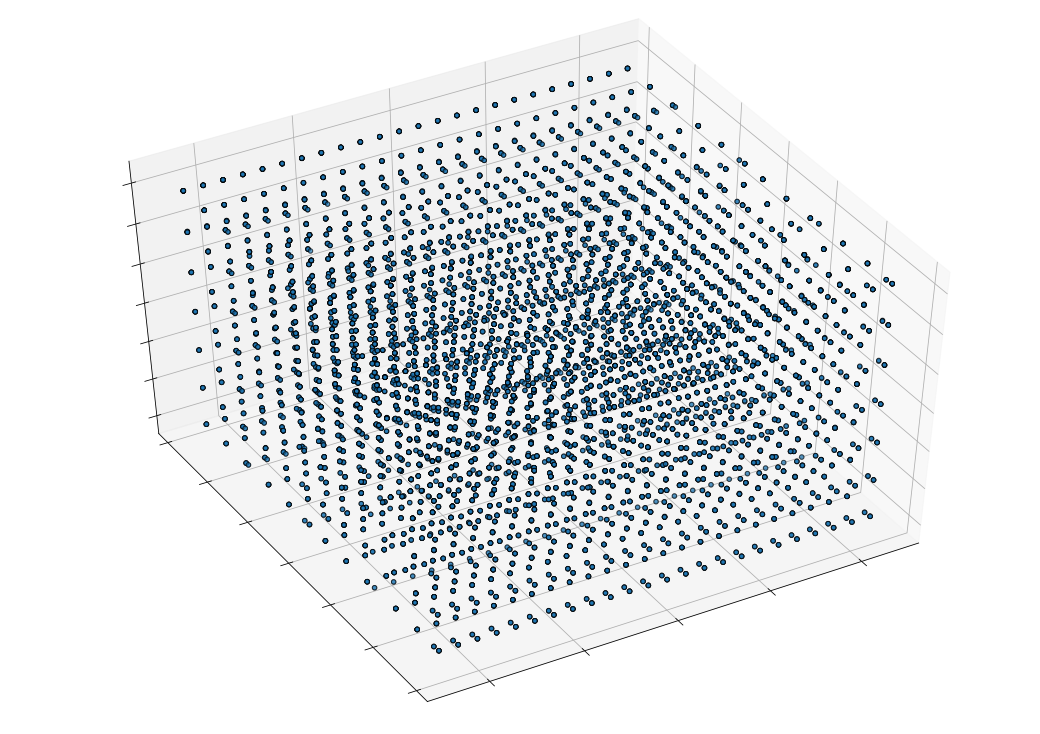

In [8]:
# Dimensionality reduction with PCA
from mpl_toolkits.mplot3d import Axes3D

pca = PCA(n_components=3)
pca.fit(X)
X_pca3 = pca.transform(X)

print(f'Explained variance {pca.explained_variance_ratio_.sum()}')

fig = plt.figure(1, figsize=(15, 10))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=60)
ax.scatter(X_pca3[:, 0], X_pca3[:, 1], X_pca3[:, 2], edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

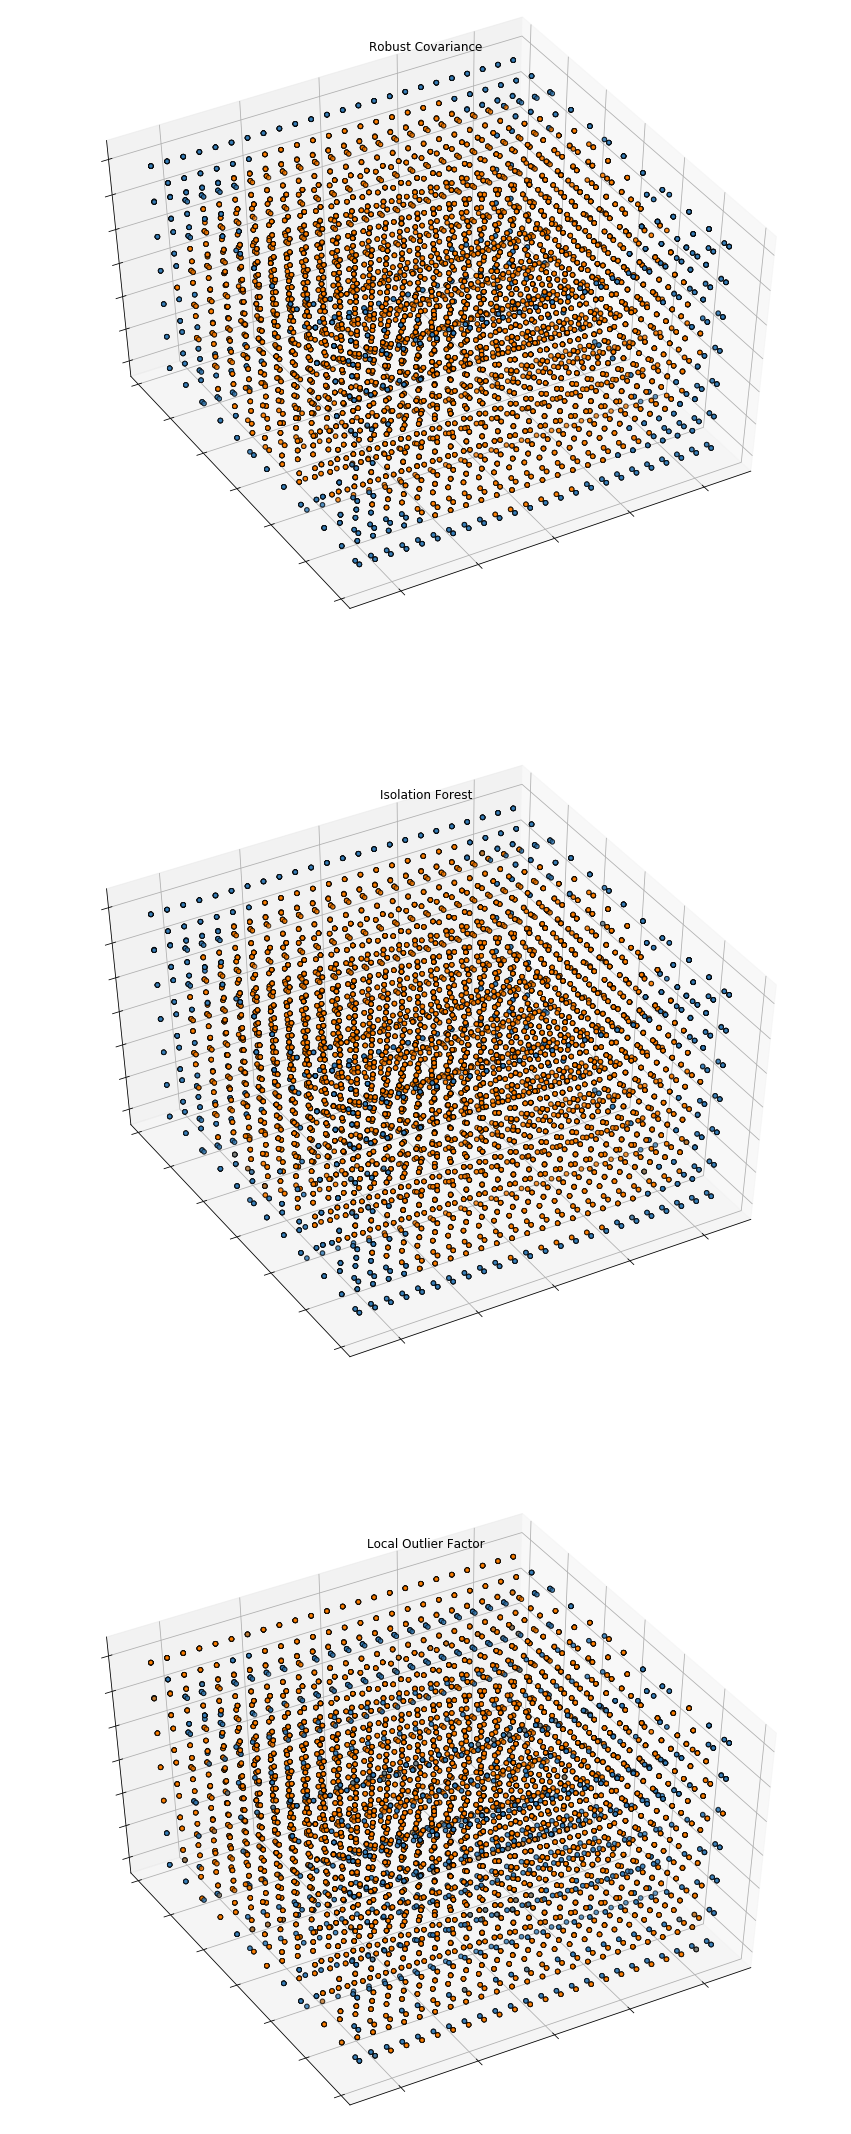

In [9]:
# Look for outliers
# use PCA's output
X = X_pca3

n_samples = len(X)
outliers_fraction = 0.15
n_outliers = int(outliers_fraction * n_samples)
n_inliers = n_samples - n_outliers
lof_n_neigbors = 35
rnd_state = 42

# define outlier/anomaly detection methods to be compared
det_algs = [
    ("Robust Covariance", EllipticEnvelope(contamination=outliers_fraction)),
    ("Isolation Forest", IsolationForest(behaviour='new',
                                         contamination=outliers_fraction,
                                         random_state=rnd_state)),
    ("Local Outlier Factor", LocalOutlierFactor(
        n_neighbors=lof_n_neigbors, contamination=outliers_fraction))]

fig = plt.figure(figsize=(15, 39))

for index, (alg_name, alg) in enumerate(det_algs):
    if alg_name == "Local Outlier Factor":
        y_pred = alg.fit_predict(X)
    else:
        y_pred = alg.fit(X).predict(X)

    colors = np.array(['#377eb8', '#ff7f00'])
    
    ax = fig.add_subplot(311 + index, projection='3d', elev=48, azim=60)
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=colors[(y_pred + 1) // 2], edgecolor='k')

    ax.w_xaxis.set_ticklabels([])
    ax.w_yaxis.set_ticklabels([])
    ax.w_zaxis.set_ticklabels([])
    ax.set_title(alg_name)
plt.show()